# Set Environment

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Set Seed for Reproducibility

In [2]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Read Image and Check Shape

(128, 128, 3)


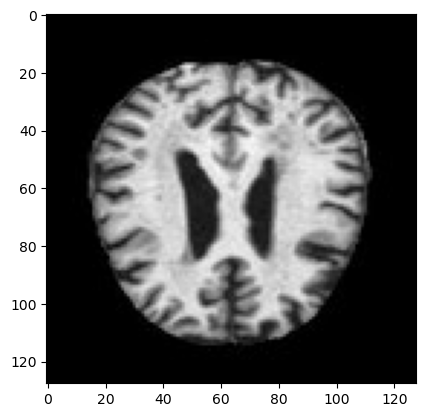

In [3]:
image = cv2.imread('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/mild_119.jpg')
image_shape = image.shape
print(image_shape)
plt.imshow(image)

# Create Dataset

In [4]:
mild = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/*.jpg')
moderate = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/*.jpg')
non = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/*.jpg')
verymild = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented/*.jpg')

data = []
labels = []

#image_size = (32,32)

for i in mild:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(0)
    
for i in moderate:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(1)

for i in non:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(2)

for i in verymild:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(3)

    
x=np.array(data)
y=np.array(labels)
print(f'Dataset Shape: {x.shape}, Labels Shape: {y.shape}')

class_names = list(['mild','moderate','non','verymild'])
print(class_names)

Dataset Shape: (6400, 128, 128, 3), Labels Shape: (6400,)
['mild', 'moderate', 'non', 'verymild']


# Train-Test and Train-Valodation Split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=0)

# Load MobileNetV2 and Define Model

In [6]:
# Define the input shape
input_shape = x_train[0].shape

pretrained_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
pretrained_base.trainable = False

model = Sequential([
    pretrained_base,
    GlobalAveragePooling2D(),
    Dense(len(class_names), activation='softmax')
])

# Print model summary
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


# Callbacks

In [7]:
# Define the learning rate reduction callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss for learning rate reduction
    factor=0.5,            # Reduce learning rate by a factor
    patience=3,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6            # Minimum learning rate
)

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# Augmented Data Generator

In [8]:
# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,  # rotate images by 30 degrees
    #width_shift_range=0.2,  # shift images horizontally by 20% of the width
    #height_shift_range=0.2,  # shift images vertically by 20% of the height
    #shear_range=0.2,  # apply shear transformation with a shear angle of 20 degrees
    #zoom_range=0.2,  # zoom in/out images by 20%
    horizontal_flip=False,  # randomly flip images horizontally
    vertical_flip=True,  # randomly flip images vertically
    fill_mode='nearest'  # fill any newly created pixels after rotation or shifting
)

# Compile Model

In [9]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train Model

In [10]:
epochs = 100
batch_size = 64
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

history = model.fit(
    train_generator,
    validation_data=(x_val,y_val),
    epochs=epochs,
    callbacks=[lr_callback,checkpoint_callback,early_stopping_callback]
)

Epoch 1/100
73/73 [==============================] - 27s 254ms/step - loss: 1.0479 - accuracy: 0.4981 - val_loss: 0.9755 - val_accuracy: 0.5196 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - 17s 232ms/step - loss: 0.9922 - accuracy: 0.5229 - val_loss: 0.9408 - val_accuracy: 0.5319 - lr: 0.0010
Epoch 3/100
73/73 [==============================] - 16s 220ms/step - loss: 0.9642 - accuracy: 0.5400 - val_loss: 0.9760 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 4/100
73/73 [==============================] - 17s 230ms/step - loss: 0.9740 - accuracy: 0.5331 - val_loss: 0.9643 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 5/100
73/73 [==============================] - 16s 223ms/step - loss: 0.9432 - accuracy: 0.5469 - val_loss: 0.9770 - val_accuracy: 0.5380 - lr: 0.0010
Epoch 6/100
73/73 [==============================] - 17s 235ms/step - loss: 0.9482 - accuracy: 0.5385 - val_loss: 0.9155 - val_accuracy: 0.5429 - lr: 5.0000e-04
Epoch 7/100
73/73 [==============================] - 1

# Evaluate Model

In [11]:
best_model = tf.keras.models.load_model('best_model.h5')
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

30/30 [==============================] - 1s 11ms/step - loss: 0.9272 - accuracy: 0.5521
Test loss: 0.9272
Test accuracy: 0.5521


# Confusion Matrix

30/30 [==============================] - 1s 10ms/step


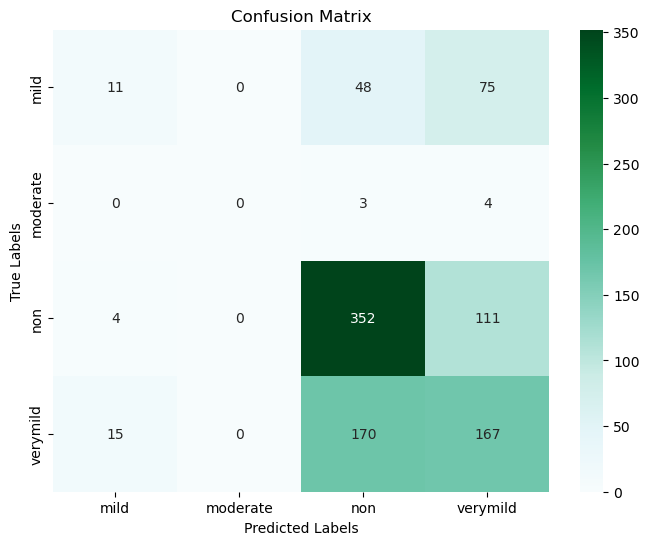

In [12]:
# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
predictions = best_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)


cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Training Curves

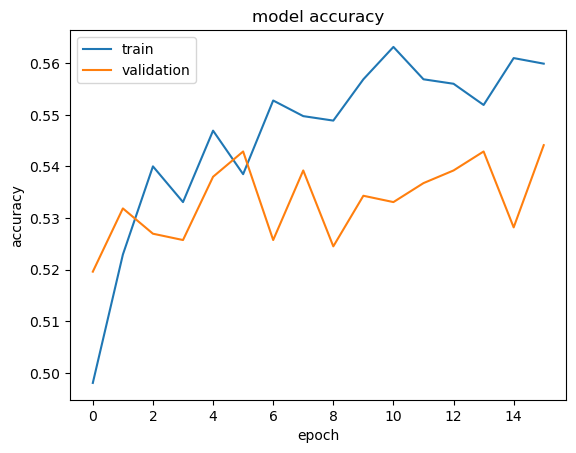

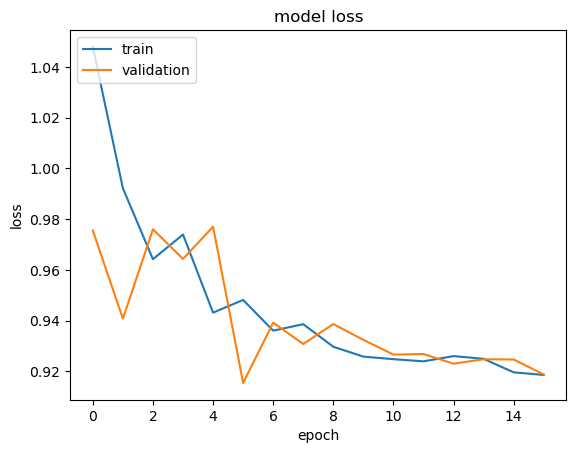

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()